In [23]:
# This notebook is used to test draculab's mechanisms for winner-take-all networks.
# By Sergio Verduzco Flores                October 2017

from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


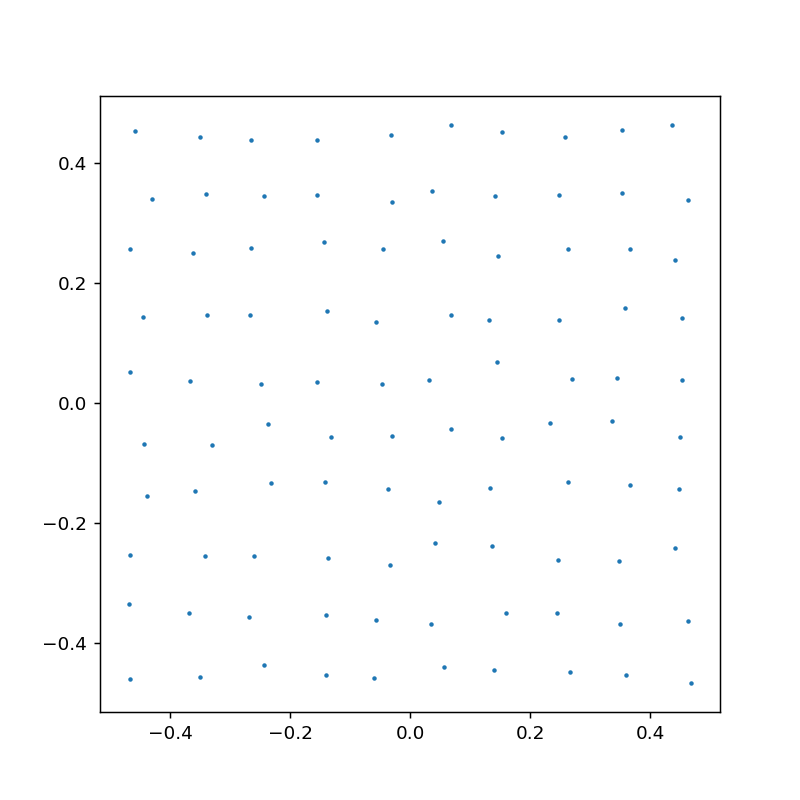

In [24]:
""" This cell creates a grid of units that make reciprocal connections to a kWTA unit. """
topo = topology()

# Create network
net_params = {'min_delay' : 0.1, 
              'min_buff_size' : 5 } # parameter dictionary for the network
net = network(net_params)

# Create group of units
unit_pars = {'init_val' : 0.5, 
             'slope' : 10.,
             'thresh' : 1.,
             'tau' : 0.01,
             'type' : unit_types.sigmoidal } 
geom = {'shape':'sheet', 
        'extent':[1.,1.], 
        'center':[0.,0.], 
        'arrangement':'grid', 
        'rows':10, 
        'columns':10, 
        'jitter' : 0.02 }
units = topo.create_group(net, geom, unit_pars)

xcoords = [ u.coordinates[0] for u in net.units ]
ycoords = [ u.coordinates[1] for u in net.units ]

# Create a kWTA unit
kwta_pars = {'init_val' : 0.1, 
             'k' : 2,
             'des_act' : 0.5,
             'type' : unit_types.kwta }
kwta = net.create(1, kwta_pars)

# Create some input units
n_inp = 4 # number of input units
inp_pars = {'type' : unit_types.source,
            'init_val' : 0.,
            'function' : lambda x: None }
inp = net.create(n_inp, inp_pars)

# Connect the group with the kWTA unit
k2u_conn_spec = {'rule' : 'all_to_all', 
                 'delay' : net_params['min_delay'] }
k2u_syn_spec = {'type' : synapse_types.static,
                'init_w' : -1. }
net.connect(units, kwta, k2u_conn_spec, k2u_syn_spec)
net.connect(kwta, units, k2u_conn_spec, k2u_syn_spec)

# Connect the inputs to the units
i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : net_params['min_delay'] }
i2u_syn_spec = {'type' : synapse_types.static,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.3} }
net.connect(inp, units, i2u_conn_spec, i2u_syn_spec)

#figg = plt.figure(figsize=(6,6))
#plt.scatter(xcoords, ycoords, s=2.)
#plt.show()

In [12]:
""" This cell runs a simulation. """
# This function creates a function implementing a localized sinusoidal bump
def make_sin_pulse(t_init, t_end, per, amp): 
    return lambda t : amp * ( np.sqrt( 0.5 * 
                     (1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < t_end) else 0.

# This function returns an input vector. Different distributions can be implemented with this.
def input_vector():
    # right now it's just random vectors with unit norm
    vec = np.random.uniform(0., 1., n_inp)
    return  vec / np.linalg.norm(vec)

n_pres = 5 # number of input presentations
sim_time = 0. # amount of time simulated so far
pres_time = 5. # time required by an individual input presentation
all_times = []
all_activs = []
for pres in range(n_pres):
    print('Starting presentation ' + str(pres))
    t = net.sim_time
    inp_vec = input_vector()
    for i in inp:
        net.units[i].set_function(make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-inp[0]]))
        
    times, activs, plants = net.run(pres_time)
    
    all_times.append(times)
    all_activs.append(activs)

all_times = np.concatenate(all_times)
all_activs = np.concatenate(all_activs, axis=1)

Starting presentation 0
Starting presentation 1
Starting presentation 2
Starting presentation 3
Starting presentation 4


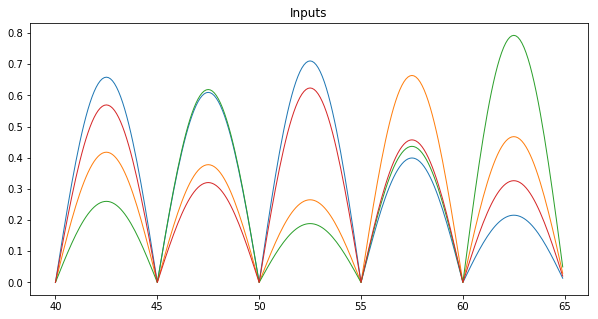

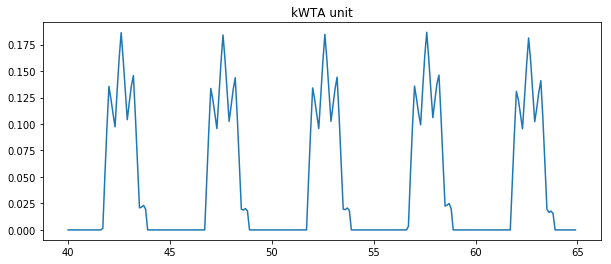

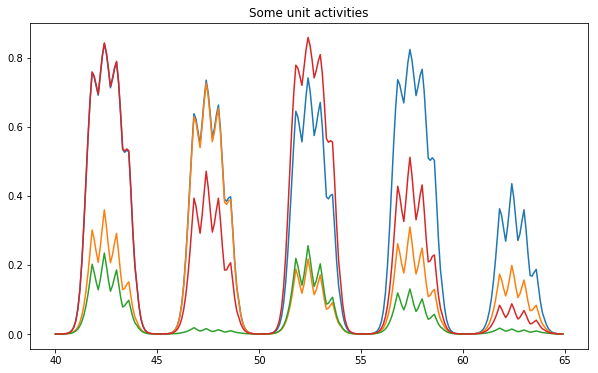

In [13]:
# Plots
%matplotlib inline
inp_fig = plt.figure(figsize=(10,5))
inputs = np.transpose([all_activs[i] for i in inp])
plt.plot(all_times, inputs, linewidth=1)
plt.title('Inputs')

inh_fig = plt.figure(figsize=(10,4))
plt.plot(all_times, all_activs[kwta[0]])
plt.title('kWTA unit')

unit_fig = plt.figure(figsize=(10,6))
some_acts = np.transpose(all_activs[[units[i] for i in [0,1,-1,-2]]])
plt.plot(all_times, some_acts)
plt.title('Some unit activities')

plt.show()

<IPython.core.display.Javascript object>


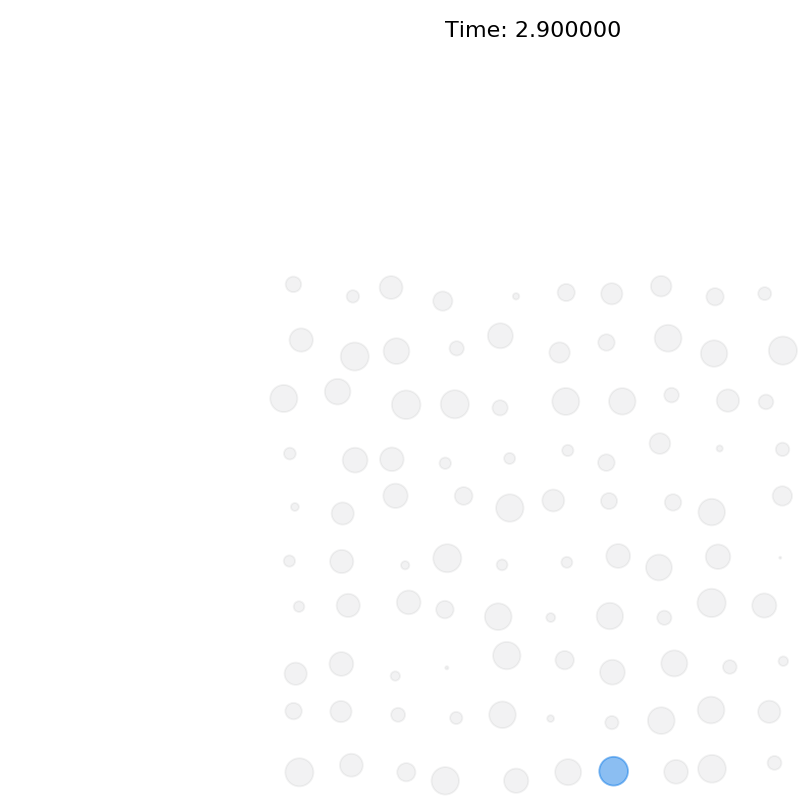

In [14]:
""" An animation to visualize the activity of the units. """
%matplotlib notebook 
# The 'notebook' backend is compatible with FuncAnimation

unit_fig = plt.figure(figsize=(8,8))
ax = unit_fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-1, 1), ax.set_xticks([])
ax.set_ylim(-1, 1), ax.set_yticks([])
scat = ax.scatter(xcoords, ycoords, s=20.*all_activs[units,0])

def color_fun(activ):
    # given the units activity, maps into a color. activ may be an array.
    activ = 0.1 + activ*np.maximum(np.sign(activ - 0.8), 0.)
    return np.outer(activ, np.array([0., .5, 1., .5]))

n_data = len(all_activs[0])
def update(frame):
    # Each frame advances one simulation step (min_delay time units)
    idx = frame%n_data
    cur_time = net.min_delay*idx
    scat.set_sizes(300.*all_activs[units,idx])
    scat.set_color(color_fun(all_activs[units,idx]))
    unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))

animation = FuncAnimation(unit_fig, update, interval=100)
plt.show()    

In [1]:
% reset -f

from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation

In [3]:
""" This cell creates Exc. and Inh. grids, and sets Mexican-hat lateral connections. 
    It is almost a clone of the kWTA network above, but the inhibition now comes from another grid. 
"""
topo = topology()

# Create network
net_params = {'min_delay' : 0.1, 
              'min_buff_size' : 5 } # parameter dictionary for the network
net = network(net_params)

# Create group of excitatory units
unit_pars = {'init_val' : 0.5, 
             'slope' : 2.,
             'thresh' : 1.,
             'tau' : 0.1,
             'tau_fast' : 0.2,
             'tau_slow' : 1.,
             'type' : unit_types.sigmoidal } 
geom = {'shape':'sheet', 
        'extent':[1.,1.], 
        'center':[0.,0.], 
        'arrangement':'grid', 
        'rows':10, 
        'columns':10, 
        'jitter' : 0.02 }
units = topo.create_group(net, geom, unit_pars)

xcoords = [ u.coordinates[0] for u in net.units ]
ycoords = [ u.coordinates[1] for u in net.units ]

# Create group of inhibitory units
inh_pars = {'init_val' : 0.5, 
            'slope' : 4.,
            'thresh' : .5,
            'tau' : 0.1,
            'tau_fast' : 0.2,
            'tau_slow' : 1.,
            'type' : unit_types.sigmoidal } 
inh = topo.create_group(net, geom, inh_pars)

# Create some input units
n_inp = 4 # number of input units
inp_pars = {'type' : unit_types.source,
            'init_val' : 0.,
            'tau_fast' : 0.2,
            'function' : lambda x: None }
inp = net.create(n_inp, inp_pars)

# E-E connections
e2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : {'gaussian' : {'p_center' : 1.1, 'sigma' : 0.3} },
            'delays' : {'linear' : {'c' : net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.3, 'a' : 0.1}},
            'number_of_connections' : 6,
            'allow_autapses' : True,
            'allow_multapses' : False,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(geom['center']), 'extent' : geom['extent']} }
e2e_syn = {'type' : synapse_types.static }
topo.topo_connect(net, units, units, e2e_conn, e2e_syn)

# E-I connections
e2i_conn = {'connection_type' : 'convergent',
            'mask' : {'annular': {'inner_radius': 0.15, 'outer_radius': 0.4}},
            'kernel' : 1.,
            'delays' : {'linear' : {'c' : net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.1, 'a' : 0.01}},
            #'number_of_connections' : 14,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(geom['center']), 'extent' : geom['extent']} }
e2i_syn = {'type' : synapse_types.static }
topo.topo_connect(net, units, inh, e2i_conn, e2i_syn)

# I-E connections
i2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : 1,
            'delays' : {'linear' : {'c' : net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : -.1, 'a' : 0.001}},
            'edge_wrap' : True,
            'boundary' : {'center': np.array(geom['center']), 'extent' : geom['extent']} }
i2e_syn = {'type' : synapse_types.static }
topo.topo_connect(net, inh, units, i2e_conn, i2e_syn)


# Connect the inputs to the units
i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : net_params['min_delay'] }
i2u_syn_spec = {'type' : synapse_types.bcm,
                'lrate' : 0.1,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.} }
net.connect(inp, units, i2u_conn_spec, i2u_syn_spec)
net.connect(inp, inh, i2u_conn_spec, i2u_syn_spec)


In [4]:
""" This cell runs a simulation. """
# This function creates a function implementing a localized sinusoidal bump
def make_sin_pulse(t_init, t_end, per, amp): 
    return lambda t : amp * ( np.sqrt( 0.5 * 
                     (1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < t_end) else 0.

# This function returns an input vector. Different distributions can be implemented with this.
def input_vector():
    # right now it's just random vectors with unit norm
    vec = np.random.uniform(0., 1., n_inp)
    return  vec / np.linalg.norm(vec)

n_pres = 10 # number of input presentations
sim_time = 0. # amount of time simulated so far
pres_time = 3. # time required by an individual input presentation
all_times = []
all_activs = []
start_time = time.time()
for pres in range(n_pres):
    print('Starting presentation ' + str(pres))
    t = net.sim_time
    inp_vec = input_vector()
    for i in inp:
        net.units[i].set_function(make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-inp[0]]))
        
    times, activs, plants = net.run(pres_time)
    
    all_times.append(times)
    all_activs.append(activs)

all_times = np.concatenate(all_times)
all_activs = np.concatenate(all_activs, axis=1)
print('Execution time is %s seconds' % (time.time() - start_time)) 

Starting presentation 0
Starting presentation 1
Starting presentation 2
Starting presentation 3
Starting presentation 4
Starting presentation 5
Starting presentation 6
Starting presentation 7
Starting presentation 8
Starting presentation 9
Execution time is 254.29275393486023 seconds


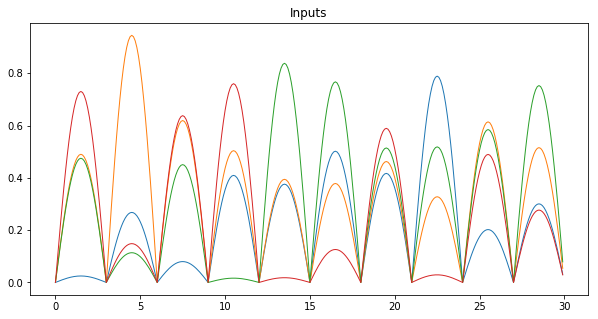

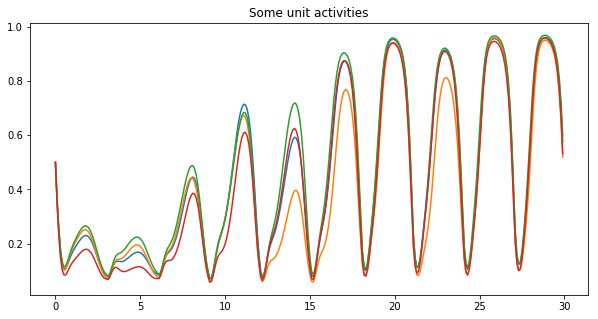

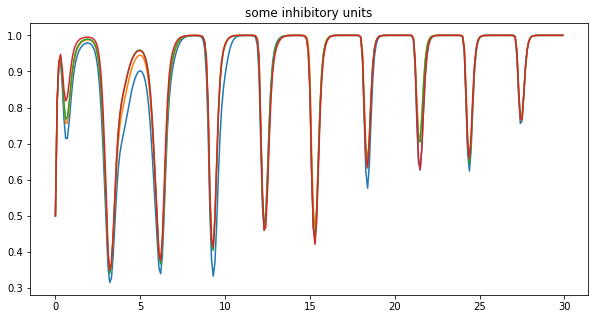

In [5]:
# Plots
#%matplotlib inline
inp_fig = plt.figure(figsize=(10,5))
inputs = np.transpose([all_activs[i] for i in inp])
plt.plot(all_times, inputs, linewidth=1)
plt.title('Inputs')

unit_fig = plt.figure(figsize=(10,5))
some_acts = np.transpose(all_activs[[units[i] for i in [0,1,-1,-2]]])
plt.plot(all_times, some_acts)
plt.title('Some unit activities')

inh_fig = plt.figure(figsize=(10,5))
some_inh = np.transpose(all_activs[[inh[i] for i in [0,1,-1,-2]]])
plt.plot(all_times, some_inh)
plt.title('some inhibitory units')

plt.show()

<IPython.core.display.Javascript object>


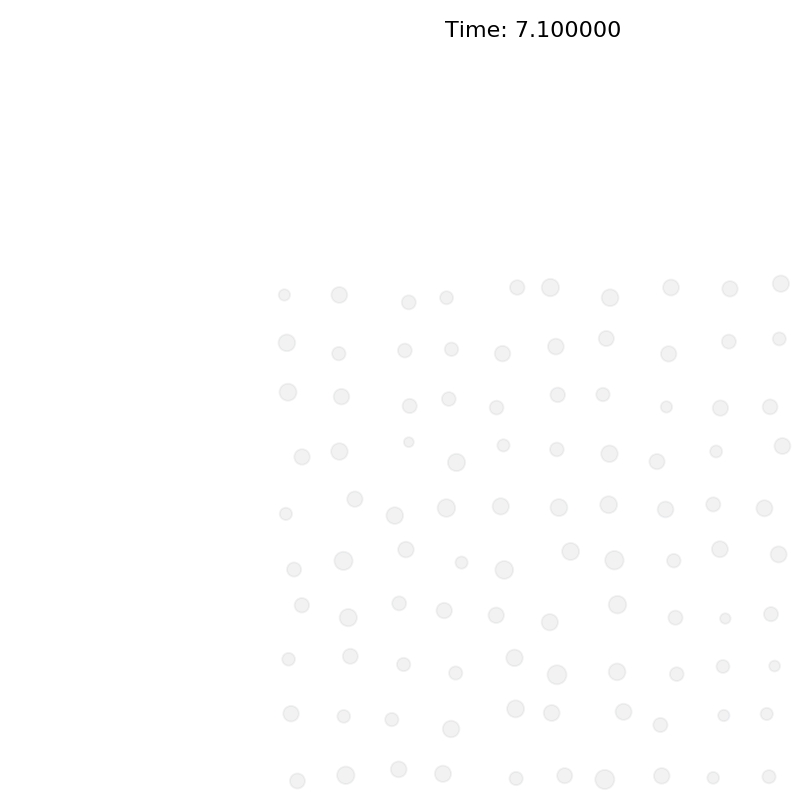

In [6]:
""" An animation to visualize the activity of the excitatory units. """
from matplotlib.animation import FuncAnimation
%matplotlib notebook 
# The 'notebook' backend is compatible with FuncAnimation

unit_fig = plt.figure(figsize=(8,8))
ax = unit_fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-1, 1), ax.set_xticks([])
ax.set_ylim(-1, 1), ax.set_yticks([])
scat = ax.scatter(xcoords, ycoords, s=20.*all_activs[units,0])

def color_fun(activ):
    # given the units activity, maps into a color. activ may be an array.
    activ = 0.1 + activ*np.maximum(np.sign(activ - 0.8), 0.)
    return np.outer(activ, np.array([0., .5, 1., .5]))

n_data = len(all_activs[0])
def update(frame):
    # Each frame advances one simulation step (min_delay time units)
    idx = frame%n_data
    cur_time = net.min_delay*idx
    scat.set_sizes(300.*all_activs[units,idx])
    scat.set_color(color_fun(all_activs[units,idx]))
    unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))

animation = FuncAnimation(unit_fig, update, interval=200)
plt.show()    

<IPython.core.display.Javascript object>


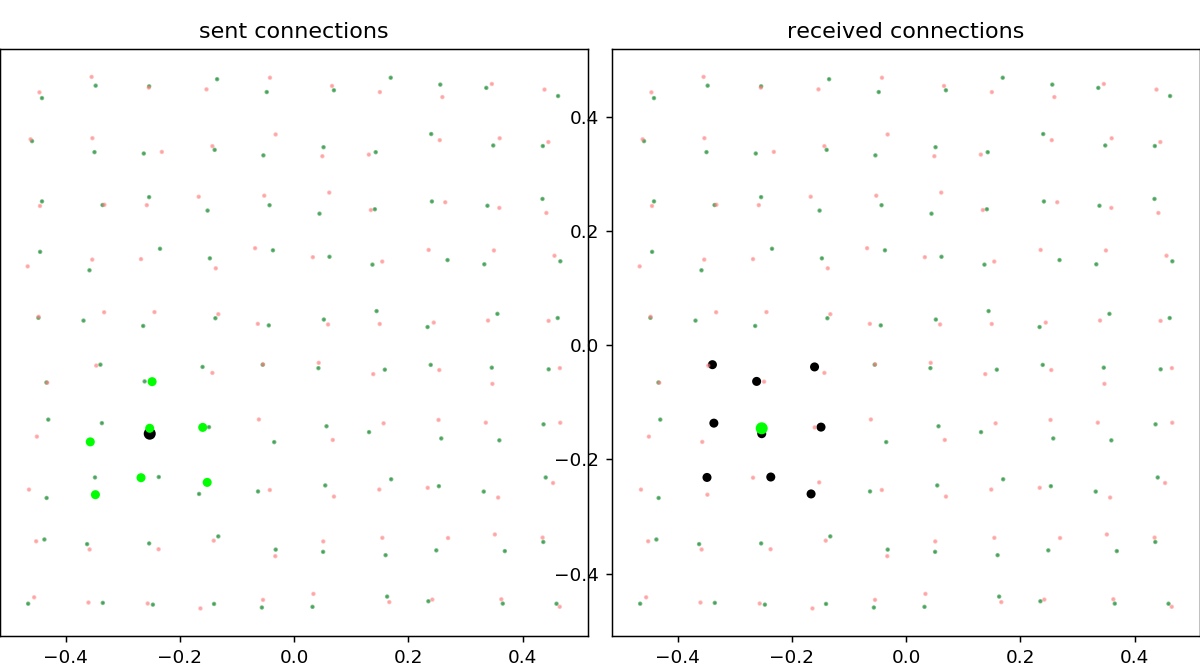

In [3]:
""" An animation to visualize the connectivity of Exc. and Inh. populations. """
# The 'notebook' backend is compatible with FuncAnimation
%matplotlib notebook 

source = inh # group of units sending the connections we'll visualize
sink = units # group of units receiving the connections

# flattening net.syns, leaving only the source-sink connections 
all_syns = []
for syn_list in [net.syns[i] for i in sink]:
    syn_list = [s for s in syn_list if s.preID in source]
    all_syns += syn_list
    
# getting lists with the coordinates of all source, sink units
source_coords = [u.coordinates for u in [net.units[i] for i in source]]
sink_coords = [u.coordinates for u in [net.units[i] for i in sink]]
source_x = [c[0] for c in source_coords]
source_y = [c[1] for c in source_coords]
sink_x = [c[0] for c in sink_coords]
sink_y = [c[1] for c in sink_coords]

# setting colors
std_src = [0., 0.5, 0.1, 0.5]
std_snk = [1., 0.5, 0.5, 0.5]
big_src = [0., 0., 0., 1.]
big_snk = [0., 1., 0., 1.]

# constructing figure, axes, path collections
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
ax2 = fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
src_col1 = ax1.scatter(source_x, source_y, s=2, c=std_src)
snk_col1 = ax1.scatter(sink_x, sink_y, s=2, c=std_snk)
src_col2 = ax2.scatter(source_x, source_y, s=2, c=std_src)
snk_col2 = ax2.scatter(sink_x, sink_y, s=2, c=std_snk)
ax1.set_title('sent connections')
ax2.set_title('received connections')

# At each frame we'll visualize the connections for a single sender and single receiver
def update(frame): 
    sou_u = frame%len(source) # source unit whose receivers we'll visualize
    snk_u = frame%len(sink) # sink unit whose senders we'll visualize
    
    # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
    source_sizes = np.tile(2,len(source))
    sink_sizes = np.tile(2,len(sink))
    source_colors = np.tile(std_src,(len(source),1))
    sink_colors = np.tile(std_snk, (len(sink),1))
    source_sizes[sou_u] = 30
    source_colors[sou_u] = big_src
    # getting targets of projections from the unit 'sou_u'
    targets = [syn.postID - sink[0] for syn in all_syns if syn.preID == sou_u + source[0]]
    # setting the colors and sizes
    sink_colors[targets] = big_snk
    sink_sizes[targets] = 15
    src_col1.set_sizes(source_sizes)
    #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
    snk_col1.set_sizes(sink_sizes)   
    src_col1.set_color(source_colors)
    snk_col1.set_color(sink_colors)
        
    # PLOTTING THE SENDERS TO sin_u ON THE RIGHT AXIS
    source_sizes = np.tile(2,len(source))
    sink_sizes = np.tile(2,len(sink))
    source_colors = np.tile(std_src,(len(source),1))
    sink_colors = np.tile(std_snk, (len(sink),1))
    sink_sizes[snk_u] = 30
    sink_colors[snk_u] = big_snk
    # getting senders of projections to the unit 'snk_u'
    senders = [syn.preID - source[0] for syn in all_syns if syn.postID == snk_u + sink[0]]
    # setting the colors and sizes
    source_colors[senders] = big_src
    source_sizes[senders] = 15
    src_col2.set_sizes(source_sizes)
    snk_col2.set_sizes(sink_sizes)   
    src_col2.set_color(source_colors)
    snk_col2.set_color(sink_colors)
    
    return ax1,ax2,

animation = FuncAnimation(fig, update, interval=500, blit=True)
plt.show()

In [37]:
max(np.abs([-5,1,2,3]))

5